<a href="https://colab.research.google.com/github/Minarose/Machine-Learning/blob/main/EEG_Signal_Reconstruction_CAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEG Signal Reconstruction Using Convolutional Autoencoder

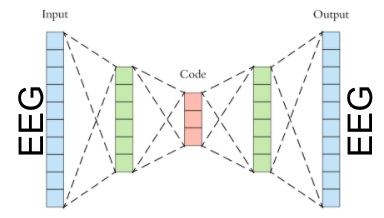

Electroencephalography (EEG) is the most common non-invasive neuroimaging technique used in medical and clinical applications today. 

Due to their capacity to capture spatial and temporal features by applying relevant filters, convolutional neural networks (CNNs) have been commonly adopted for time-series applications like EEG signals. Specifically, convolutional autoencoders (CAEs) can be employed to extract features for signal classification methods like epileptic seizure detection or tasks targeted by brain-computer interface (BCI) technology. CAEs are a variant of CNNs that utilize a bottleneck effect to reconstruct input features
from a compressed latent representation. This forces the network to filter out redundancies and learn only the variations in the data needed to reconstruct the relevant data (Ditthapron et al., 2019). AEs are trained by minimizing reconstruction error. 

In this project, I construct a convolutional autoencoder (CAE) that attempts to reconstruct the original EEG signal from the lowest representation in the latent space using a Mean Square Error (MSE) loss.

# Note: this notebook uses Google Colab's GPU accelerator

# Packages

In [ ]:
# the essentials
import matplotlib.pyplot as plt
import numpy as np
#mne consists of python packages used to visualize EEG data 
! pip install mne
import mne
#Tensorflow backened Keras API for model construction and training
import tensorflow as tf
from keras.layers import Input, Reshape, Conv2DTranspose, Flatten, Conv2D, Dense, MaxPooling2D, Dropout,BatchNormalization, UpSampling2D,Activation
from keras.models import Sequential, Model, Input, InputLayer
from keras import backend as K

# Data

I used a resting-state EEG dataset made publicly available by Deligianni et
al. and can be found at Open Science Framework (https://osf.io/rmuje/). The data is composed of imaging data from 17 adult volunteers (11 males, 6
females, mean age: 32.84 +/- 8.13 years).

In this project I only use the preprocessed EEG data of the first subject - subject '32'

After downsampling the EEG data to a
sampling rate of 128 Hz, I split the data into 2-second non-overlapping epochs producing 256-time samples. This gives us 323 samples for the first subject.

## Import


[Link to preprocessed version of subject 32's data from my google drive](https://drive.google.com/file/d/1aOltBCjeGBxCIw-rByU6dyjZMmUJ_yuQ/view?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
raw = mne.io.read_raw_fif('/content/drive/MyDrive/export_preprocessed/32p.fif', preload=True)

## Shaping

In [ ]:
sr = 128 # standard EEG sampling rate (Hz)
seglen = 2 # segement length in seconds (by choice)
ns = sr*seglen # number of seconds
train_prop = 0.8 #proportion of data set aside for model training

In [ ]:
#EEG data often contains signals from non-EEG channels. Here we make sure to extract the signals from EEG signals only.
data = raw.get_data(picks='eeg')

n_segments = data.shape[1]//ns
X = np.array([data[:,(i*ns):(i*ns+ns)]for i in range(n_segments)])
print("total number of samples", X.shape[0])
print("# of channels is", X.shape[1])
print("# of seconds in each sample is", X.shape[-1])

total number of samples 323
# of channels is 63
# of seconds in each sample is 256


In [ ]:
#scaling data using mne package for EEG data
scaler = mne.decoding.Scaler(info=raw.info, scalings='mean', with_mean=True, with_std=True)
X_scaled = mne.decoding.Scaler.fit_transform(scaler, X, y = None)

## Training & Test Sets

I employ one round of cross-validation. Cross-validation allows us to observe how a model will perform on an unknown dataset. I generated a training set and a validation set by assigning 80% of the samples for the training set and the remaining 20% of the samples for the
validation set. This resulted in 258/323 samples in the training set, and 65/323 samples in the validation set that are
used by the neural network models to monitor losses. The model uses the training set to learn
reconstructing EEG signals and the validation set to test how well the model can reconstruct new data.

In [ ]:
n_train = int(n_segments*train_prop)
X_train = X_scaled[:n_train]
X_test = X_scaled[n_train:]
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)
n_test, _, n_chan, n_samp = X_test.shape
print("training set has", X_train.shape[0],"samples")
print("validation set has", X_test.shape[0], "samples")

training set has 258 samples
validation set has 65 samples


# Model

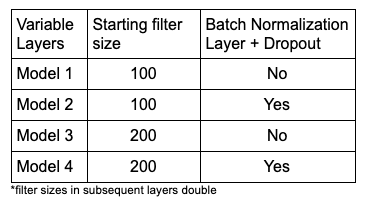

Architecture, code & results of model 4 (best model) has been chosen to be shown here.

EEG reconstruction CAE Model 4 consists of 10 layers in the encoder and 10 layers in the
decoder. 
The encoder employs a spatial convolution to encode the spatial dependencies in the channel space
followed by a series of temporal convolutional layers in order to capture oscillatory dynamics of the EEG
signals at different time scales.
I set the inputs for the encoder model for 63 EEG channels with 256-time samples. I start
with 200 filters in a spatial depthwise 2D convolutional layer of the encoder that learns spatial filters for
63 channels. The following 2D convolutional layers convolve temporally across 256-time samples where
the filter number doubles in every layer. The inputs to the encoders are padded so the output size is the
same as the input size to make the input layer divisible by 2^ 8 and ensure that rounding errors do not lead
to mismatched layer dimensions between the encoders and the decoder. Each temporal convolutional
layer is followed by a batch-normalization layer (BN) and the eLU activation layer. Batch Normalization layers force activation throughout the network to take on a unit gaussian distribution at begining of training. It tends to reduce overfitting (Ioffe and Szegedy, 2015). I chose to omit the use of a dense layer since the model's purpose was reconstruction and not classification.

The decoder conserves the architecture in the encoder but reverses the order of layers making our
autoencoder model symmetrical.
Each convolutional or transpose convolutional block in the encoder and decoder is followed by a
max-pooling layer that downsamples its input by half or an up-sampling layer that doubles the size of its
input. I follow this with a dropout layer (rate = 0.5) to prevent the hidden units from relying on one
another and encoding redundant information. This regularizes the weights by randomly removing half of
the hidden units in the layer for each training batch.

### Architecture



In [ ]:
K.set_image_data_format('channels_first')
input_shape = (None,1,n_chan, n_samp)
input_ = Input(shape=(1,n_chan, n_samp))
encoder= None
decoder = None
autoencoder = None

encoder = Sequential((
    InputLayer(batch_input_shape=input_shape, name='encoder_input3'),
    Conv2D(filters=200,kernel_size = (1,5),padding = "same",data_format='channels_first'),
    Conv2D(filters=200,kernel_size = (63, 1), use_bias=False),
    BatchNormalization(axis=3, momentum=0.1, epsilon=0.00001), Activation("elu"),
    MaxPooling2D(pool_size=(1,2), strides=(1,2)),
    Dropout(rate = 0.5),
    Conv2D(filters=400, kernel_size = (1,5), padding = "same", use_bias=False,data_format='channels_first'),
    BatchNormalization(axis=3, momentum=0.1, epsilon=0.00001), Activation("elu"),
    MaxPooling2D(pool_size=(1,2), strides = (1,2)),
    Dropout(rate = 0.5),
    Conv2D(filters=800, kernel_size = (1,5),padding = "same", use_bias=False, data_format='channels_first'),
    BatchNormalization(axis=3, momentum=0.1, epsilon=0.00001), Activation("elu"),
    MaxPooling2D(pool_size=(1,2), strides=(1,2)),Dropout(rate = 0.5),
    Conv2D(filters=1600, kernel_size = (1,5),padding = "same", use_bias=False, data_format='channels_first'),
    BatchNormalization(axis=3, momentum=0.1, epsilon=0.00001), Activation("elu"),
    MaxPooling2D(pool_size=(1,2), strides=(1,2)),
    Dropout(rate = 0.5),
    Flatten(data_format='channels_first')
    
))

decoder = Sequential((
    Reshape((1600,1,16), input_shape=encoder.output_shape),
    Conv2DTranspose(filters=1600,kernel_size = (1,5),padding = "same", use_bias=False, data_format='channels_first'),
    BatchNormalization(axis=3, momentum=0.1, epsilon=0.00001), Activation("elu"),
    UpSampling2D(size=(1,2)),Dropout(rate = 0.5),
    Conv2DTranspose(filters=800,kernel_size = (1,5),padding = "same", use_bias=False, data_format='channels_first'),
    BatchNormalization(axis=3, momentum=0.1, epsilon=0.00001), Activation("elu"),
    UpSampling2D(size=(1,2)),Dropout(rate = 0.5),
    Conv2DTranspose(filters=400,kernel_size = (1,5),padding = "same", use_bias=False,data_format='channels_first'),
    BatchNormalization(axis=3, momentum=0.1, epsilon=0.00001), Activation("elu"),
    UpSampling2D(size=(1,2)),Dropout(rate = 0.5),
    Conv2DTranspose(filters=200,kernel_size = (1,5),padding = "same", use_bias=False,data_format='channels_first'),
    BatchNormalization(axis=3, momentum=0.1, epsilon=0.00001), Activation("elu"),
    UpSampling2D(size=(1,2)),Dropout(rate = 0.5),
    Conv2DTranspose(filters=200,kernel_size = (63,1), use_bias=False),
    Conv2DTranspose(filters=1,kernel_size = (1,1),padding = "same", use_bias=False,data_format='channels_first')
))

In [ ]:
autoencoder = Model(input_, decoder(encoder(input_)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 63, 256)]      0         
_________________________________________________________________
sequential (Sequential)      (None, 25600)             10923120  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1, 63, 256)        23721160  
Total params: 34,644,280
Trainable params: 34,642,840
Non-trainable params: 1,440
_________________________________________________________________


### Model Training

In [ ]:
batchsize = 10 #arbitrary choice 
n_epochs = 200 #chosen until signs of overfitting were observed

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
autoencoder.compile(loss = 'mse', optimizer = optim, metrics = ['accuracy'])

In [ ]:
history = autoencoder.fit(x = X_train, y = X_train, batch_size = batchsize, epochs = n_epochs, validation_data = (X_test, X_test))

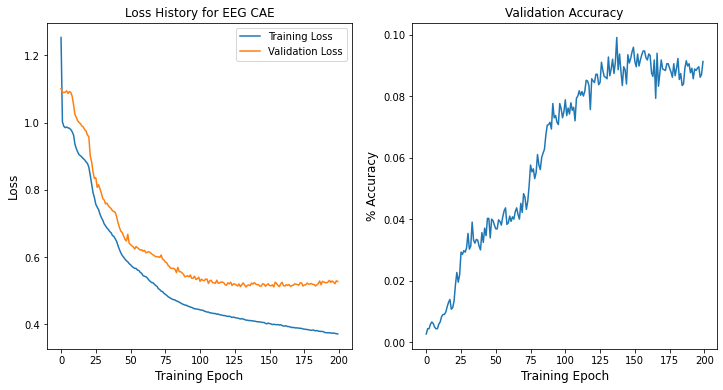

In [ ]:
N = np.arange(0, len(history.history["loss"]))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
ax1.set_xlabel('Training Epoch',fontsize = 12)
ax1.set_ylabel('Loss',fontsize = 12)
ax1.plot(N, history.history["loss"], label="Training Loss")
ax1.plot(N, history.history["val_loss"], label="Validation Loss")
ax1.set_title('Loss History for EEG CAE')
ax1.legend()
ax2.set_xlabel('Training Epoch',fontsize = 12)
ax2.set_ylabel('% Accuracy',fontsize = 12)
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Validation Accuracy')
plt.show()

The model was trained for 200 epochs and had shown early signs of overfitting just after 160 epochs of training.

Model 4 was the best model constructed so far with the highest starting filter size of 200 filters in the first layer with batch normalization and dropout layers. 

The model was able to achieve an accuracy of 10%. This may be a scenario where an accuracy metric is not the best depictor of model performance. The model also achieved a loss of 0.3 and validation loss of 0.5. This was lower than the loss achieved by a model with 100 starting filters or a model without batch normalization or dropout layers (below).The loss curves also decrease more smoothly throughout training. 


**Model 3 Loss History & Accuracy (picture of results from other notebook)**

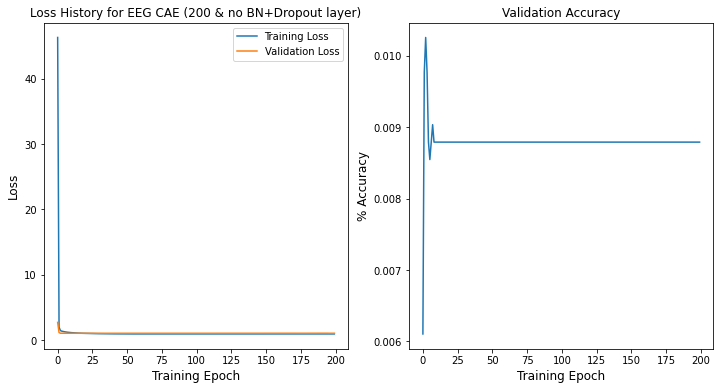

Model 3 rapidly converged with thin the first epoch. Without batch normalization and dropout layers, it seems like the model was unable to learn the filters. The learning rate may also be too high for this architecture. The accuracy of the model peaks imediately and remains at a constant value. This also shows that the model has stopped learning.

**Model 2 Loss History & Accuracy (picture of results from other notebook)**

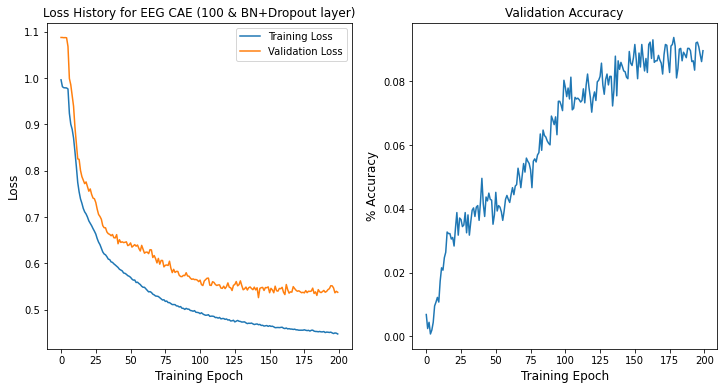

We see the batch normalization and drpout layers help the model learn the filters through the smoother convergence in the loss curves and the steady increases in accuracy. Increasing the starting filter size in model 4 decreased the valida

**Model 1 Loss History & Accuracy (picture of results from other notebook)**

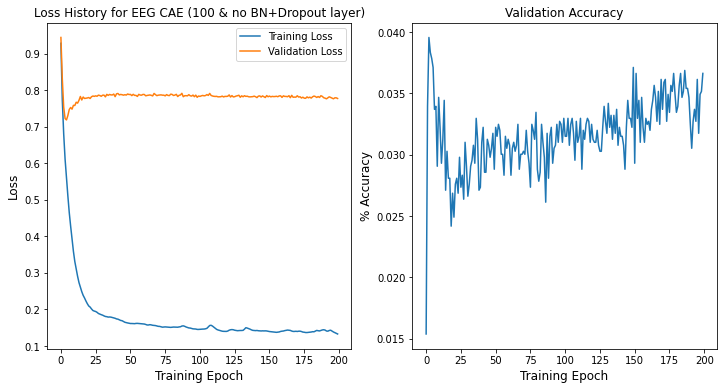

Here the training loss was a misleading metric. Although the training loss decreases to almost 0.1, the validation loss converges rapidly to around 0.7 and starts overfitting shortly after. This is also depicted by the accuracy curve as the model stops learning after 25 epochs.

### Visualization of Original vs. Predicted EEG signal

## Power Spectrum

Power of EEG signal over frequency

In [ ]:
# reconstruct EEG signal from validation set
X_pred = autoencoder.predict(X_test)
#Divide signal into epochs
test_epochs = mne.EpochsArray(np.squeeze(X_test), info=raw.info)
pred_epochs = mne.EpochsArray(np.squeeze(X_pred), info=raw.info)
#add filter for the predicted data that exists in the original data
pred_epochs.filter(None, 40.)


**Original EEG Data**

    Using multitaper spectrum estimation with 7 DPSS windows


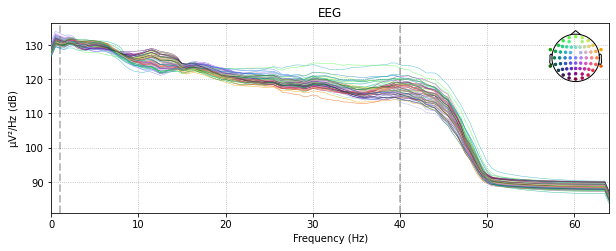

In [ ]:
test_epochs.plot_psd(average=False)
plt.show()

**Predicted EEG Data**

    Using multitaper spectrum estimation with 7 DPSS windows


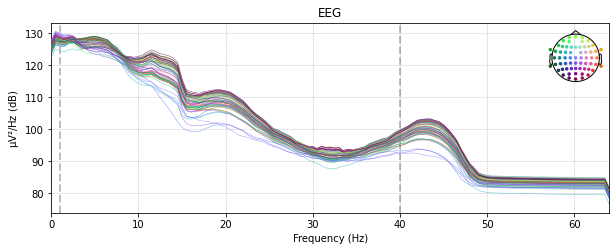

In [ ]:
pred_epochs.plot_psd(average=False)
plt.show()

The model is able to depict the power spectrum (x-axis) more closely in the lower frequency ranges (y-axis)

The model was able to reconstruct the EEG power spectrum more closely than the other models (graphs not shown here due to space).

### Topoplots

Localization of power of EEG signal on scalp by frequency range

**Original**

    Using multitaper spectrum estimation with 7 DPSS windows


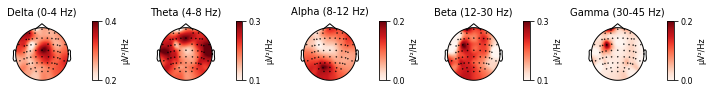

In [ ]:
#mne topoplot package settings
montage = mne.channels.make_standard_montage("standard_1020")
test_epochs.set_montage(montage)
test_epochs.plot_psd_topomap(ch_type='eeg',normalize=True)
plt.show()

**Predicted**

    Using multitaper spectrum estimation with 7 DPSS windows


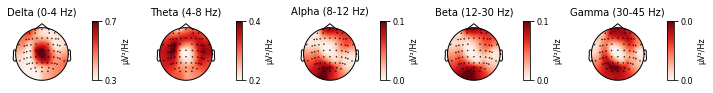

In [ ]:
pred_epochs.set_montage(montage)
pred_epochs.plot_psd_topomap(ch_type='eeg',normalize=True)
plt.show()

The model is able to localize EEG power better in the lower frequency ranges of Delta & Theta than the higher ranges

## Conclusion

In this project, I've attempted to take advantage of the features of convolutional autoencoders to reconstruct the EEG time series. The EEG signal is much more complicated in its time series representation but it also has features representated in the spatial and frequency domain. In other words, the model should be trained and penalized for the reconstruction accuracy of the EEG signal represented in the temporal, spatial and frequency domain. Here the loss function takes the MSE of the time series of the true and predicted signal. 

There can be more variables manipulated to evaluate the performance of the network including changes in hyperparameters like learning rate, batch size, optimizer and activation functions. Moreover, the model should realistically be trained on data of more subjects to evaluate cross-subject validity.

## References

Ditthapron, A., Banluesombatkul, N., Ketrat, S., Chuangsuwanich, E., & Wilaiprasitporn, T. (2019). Universal Joint Feature Extraction for P300 EEG Classification Using Multi-Task Autoencoder. IEEE Access, 7, 68415–68428. https://doi.org/10.1109/ACCESS.2019.2919143

Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. ArXiv:1502.03167 [Cs]. http://arxiv.org/abs/1502.03167

MNE EEG Visualization & Analysis Python Package
https://mne.tools/stable/index.html

Dataset source - https://osf.io/rmuje/

